In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
np.set_printoptions(precision=4, suppress=True)
mpl.style.use('dark_background')

## 1: Testing correlation function

The sample correlation coefficient for sets of samples $x_i$ and $y_i$ is given in terms of the
sample covariance $Cov$ and standard deviations $\sigma$:
$$ \rho = \frac{Cov(x, y)}{\sigma_x \sigma_y}$$
Define shifted samples $\hat{x_i} = x_i - \mu_x$ and $\hat{y_i} = y_i - \mu_y$ where $\mu_x$
and $\mu_y$ are the means of $x_i$ and $y_i$ respectively. Then
$$ \rho = \frac{\sum_i \hat{x_i} \hat{y_i}}{\sqrt{(\sum_i \hat{x_i}^2) (\sum_i \hat{y_i}^2)}} $$

In [2]:
def pixel_corr_uncentered(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(A * B, axis=0)) \
                / (np.sqrt(np.sum(A**2, axis=0) \
                            * np.sum(B**2, axis=0)) + eps)

In [3]:
def pixel_corr(A, B):
    # A and B have shape N x m x n, where images are size m x n
    # find mean value of a single pixel over the N images
    shifted_A = A - np.mean(A, axis=0)
    shifted_B = B - np.mean(B, axis=0)
    # formula given above + perturbing denominator by
    # a small eps so that a constant series gets 
    # a correlation of 0 instead of Inf or NaN
    eps = 1e-10
    return (np.sum(shifted_A * shifted_B, axis=0)) \
                / (np.sqrt(np.sum(shifted_A**2, axis=0) \
                            * np.sum(shifted_B**2, axis=0)) + eps)

In [ ]:
linear_model  = tf.keras.Sequential([
    tf.keras.layers.Dense(784, input_shape=(3920,), use_bias=False)
])
loss_fn = tf.keras.losses.MeanSquaredError()
test_model.compile(optimizer='sgd', loss=loss_fn)

In [52]:
def np_corr(A, B):
    corr_coefs = np.zeros(A.shape[1:])
    for i in range(A.shape[1]):
        for j in range(A.shape[2]):
            corr_coefs[i, j] = np.corrcoef(A[:,i,j], B[:,i,j])[0,1]
    return corr_coefs

In [66]:
# testing on example matrices
X = np.array([[[1,1],[1,1]],
              [[1,2],[2,2]],
              [[1,3],[3,3]]])
print('X:\n', X)
# (0,0) pixel should have coeff of 1 since one series is constant
# (0,1) pixel close to 1
# (1,0) pixel close to -1
# (1,1) pixel close to 0
Y = np.array([[[1,2],[8,4]],
              [[2,7],[7,8]],
              [[3,10],[1,3]]])
print('Y:\n', Y)
print('My correlation coefficients:\n', pixel_corr(X, Y))
print('Numpy correlation coefficients:\n', np_corr(X,Y))


X:
 [[[1 1]
  [1 1]]

 [[1 2]
  [2 2]]

 [[1 3]
  [3 3]]]
Y:
 [[[ 1  2]
  [ 8  4]]

 [[ 2  7]
  [ 7  8]]

 [[ 3 10]
  [ 1  3]]]
My correlation coefficients:
 [[ 0.      0.9897]
 [-0.9245 -0.189 ]]
Numpy correlation coefficients:
 [[    nan  0.9897]
 [-0.9245 -0.189 ]]


## 2: Encoding Fashion-MNIST

In [29]:
# import MNIST data set with 60,000 28x28 training images
# and 10,000 28x28 testing images (y's are labels that aren't needed)
fashion_mnist = tf.keras.datasets.fashion_mnist
(dum, train_label), (dummer, test_label) = fashion_mnist.load_data()

# normalize pixel brightnesses from 0-255 -> (0,1)
x_train, x_test = x_train / 255.0, x_test / 255.0

In [7]:
# Have d = 28*28 = 784 as the dimensionality of the input vectors.
# Encode these vectors with dxn random matrix A, where n = 5 * d
A = np.random.randn(784,5*784)

# reshape training and test data from (N, 28, 28) -> (N, 784)
x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

# rename original vectors as y_train and y_test, as these should
# be the output of the networks
y_train = x_train.copy()
y_test = x_test.copy()

# encode x_train and x_test by right-multiplying A
# x.shape = (N, d), A.shape = (d, n) -> output shape of (N, n)
x_train = x_train @ A
x_test = x_test @ A

In [9]:
# save encoded data to .npz archive
np.savez('normally-encoded-fashion-mnist.npz', x_train=x_train,
        x_test=x_test, y_train=y_train,
        y_test=y_test, A=A)

In [3]:
# import encoded data from .npz archive
with np.load('normally-encoded-fashion-mnist.npz') as data:
    x_train = data['x_train']
    x_test = data['x_test']
    y_train = data['y_train']
    y_test = data['y_test']
    A = data['A']

## 3: Use pseudo-inverse to gauge reasonable level of WGN

In [23]:
A_sharp = np.linalg.pinv(A)

In [17]:
# add white Gaussian noise (WGN) to encoded images, look at images 
# "reconstructed" via the pseudo inverse A#
sigma = np.std(x_test[0:10,:])/5 # 1/5 of std of encoded images
y_noisy = (x_test[0:10] + sigma*np.random.randn(10, 3920)) @ A_sharp

# reshape 2D arrays to 3D
original_images = np.reshape(y_test[0:10], (10,28,28))
noisy_images = np.reshape(y_noisy, (10,28,28))

# plot original and noisy images side-by-side
fig, axs = plt.subplots(10,2, figsize=(8,40),
                       constrained_layout=True)
fig.suptitle('ORIGINAL vs. NOISY', fontsize=20)
for i in range(10):
    # plot original image on the left
    left_title = "Min: {0:.5}, Max: {1:.5}".format(
        np.min(original_images[i,:,:]),
        np.max(original_images[i,:,:]))
    axs[i,0].set_title(left_title)
    axs[i,0].imshow(original_images[i,:,:],
                    cmap='gray')
    
    # plot noisy image on the right
    right_title = "Min: {0:.5}, Max: {1:.5}".format(
        np.min(noisy_images[i,:,:]),
        np.max(noisy_images[i,:,:]))
    axs[i,1].set_title(right_title)
    axs[i,1].imshow(noisy_images[i,:,:],
                    cmap='gray')
plt.show()

NameError: name 'A_sharp' is not defined

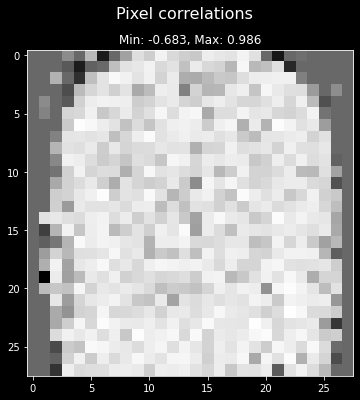

In [38]:
# calculate pixel correlations
corr = pixel_corr(original_images, noisy_images)

# plot pixel correlations
fig, ax = plt.subplots(1,1, figsize=(6,6))
fig.suptitle('Pixel correlations', fontsize=16)
title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(corr),
        np.max(corr))
ax.set_title(title)
ax.imshow(corr, cmap='gray')
plt.show()

## 4: Testing Jacobian function

In [4]:
def batch_JJt_diag(x, model):
    # note that x should be a tf.Variable with N vectors
    # of length n
    x = tf.Variable(x)
    with tf.GradientTape() as tape:
        y = model(x)
    # if each output vector in y has length d then each
    # batch of Jacobians has shape N x d x n
    jacobians = tape.batch_jacobian(y, x)
    
    # the diagonal of JJt can be obtained via summing along
    # the third axis (size n) of the elementwise square
    # of the Jacobian. The batch of JJt diagonals will 
    # be size N x d 
    return np.sum(jacobians**2, axis=2)

In [10]:
# construct single-layer, linear, unbiased network to test
# function that gets batch Jacobians
test_model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, input_shape=(7,), use_bias=False)
])
loss_fn = tf.keras.losses.MeanSquaredError()
test_model.compile(optimizer='sgd', loss=loss_fn)

In [11]:
test_x = tf.Variable(np.random.randn(3,7))
print('BATCH OF JJt DIAGONALS\n')
print('\n',batch_JJt_diag(test_x, test_model))

BATCH OF JJt DIAGONALS


 [[1.4238 1.2871 1.0668 0.3979]
 [1.4238 1.2871 1.0668 0.3979]
 [1.4238 1.2871 1.0668 0.3979]]


In [12]:
weights = test_model.weights[0].numpy()
print('TEST MODEL WEIGHTS W')
print(weights)
print('\nWtW DIAGONAL')
print(np.sum(weights**2, axis=0))

TEST MODEL WEIGHTS W
[[ 0.206   0.3612  0.6586  0.2711]
 [-0.3332  0.0754  0.1866 -0.1045]
 [ 0.5087 -0.2373  0.3994 -0.0365]
 [ 0.4839  0.0915 -0.3554  0.0638]
 [-0.2405 -0.7336 -0.5481  0.5111]
 [ 0.5946 -0.6712  0.1062 -0.1252]
 [ 0.605  -0.3125 -0.0261 -0.1766]]

WtW DIAGONAL
[1.4238 1.2871 1.0668 0.3979]


In [4]:
# deep, nonlinear network with MeanSquaredError
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(50000, activation='relu', input_shape=(5*784,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(784)
])
loss_fn = tf.keras.losses.MeanSquaredError()
full_history = {'loss':[], 'val_loss':[]}
model3.compile(tf.keras.optimizers.SGD(), loss=loss_fn)

In [7]:
start_time = time.time()
print(batch_JJt_diag(x_train[:10,:], model3))
print('Execution time: {0:.2}'.format(time.time() - start_time))

[[0.1138 0.1095 0.1191 ... 0.114  0.1199 0.1115]
 [0.1133 0.1148 0.1154 ... 0.1149 0.1199 0.1092]
 [0.1145 0.1192 0.1167 ... 0.1143 0.1209 0.1154]
 ...
 [0.1178 0.113  0.1231 ... 0.1137 0.1175 0.1095]
 [0.1099 0.1116 0.1191 ... 0.1196 0.1114 0.1056]
 [0.1123 0.1133 0.1174 ... 0.1156 0.1165 0.1149]]
Execuation time: 1.9e+02


## 5: Full training loop

In [5]:
# deep, nonlinear network with MeanSquaredError
full_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50000, activation='relu', input_shape=(5*784,)),
    tf.keras.layers.Dense(5000, activation='relu'),
    tf.keras.layers.Dense(784)
])
loss_fn = tf.keras.losses.MeanSquaredError()
loss_history = {'loss':[], 'val_loss':[]}
image_corr_history = []
JJt_corr_history = []

In [9]:
# train network on full training data set
val_size = 100
train_size = 1000
start_idx = 0
full_model.compile(tf.keras.optimizers.SGD(learning_rate=.005, momentum=0.0),
                   loss=loss_fn)
this_history = full_model.fit(x_train[start_idx:start_idx+train_size],
                              y_train[start_idx:start_idx+train_size],
                              validation_data=(x_test[:val_size], y_test[:val_size]),
                              epochs=2, verbose=1, batch_size=20)

# append to full loss history dict
loss_history['loss'] += this_history.history['loss']
loss_history['val_loss'] += this_history.history['val_loss']

# calculate correlation between output image and original image over
# 100 images
# reshape original and output batches of vectors into batches of images
output_images = np.reshape(full_model(x_test[:100]), (100,28,28))
original_images = np.reshape(y_test[:100], (100,28,28))
image_corr_history.append(pixel_corr(original_images, output_images))

# calculate correlation between the diagonal of JJt and the deviation
# between output and original images squared, specifically over 10
# sample shirt-like images
shirt_idxs = [1,4,6,7,10,14,16,17,19,20] # on test dataset
# add noise to input vectors x_test
sigma = np.std(x_test[shirt_idxs])/5 # choose sigma = 1/5 of original std
x = x_test[shirt_idxs] + sigma*np.random.randn(10, 3920)
# reshape original and output batches of vectors into batches of images
output_shirts = np.reshape(full_model(x), (10,28,28))
original_shirts = np.reshape(y_test[shirt_idxs], (10,28,28))
# get the deviation^2 pixel by pixel
dev_sq = (output_shirts - original_shirts)**2
# get batch of JJt diagonals (each length 784) and reshape into 
# a batch of 28x28 "images"
JJt_diags = np.reshape(batch_JJt_diag(x, full_model), (10,28,28))
# add correlation of dev_sq and JJt_diags to correlation history
JJt_corr_history.append(pixel_corr(dev_sq, JJt_diags))

Epoch 1/2
50/50 [==============================] - 70s 1s/step - loss: 0.1105 - val_loss: 0.1054
Epoch 2/2
50/50 [==============================] - 74s 1s/step - loss: 0.0967 - val_loss: 0.0923


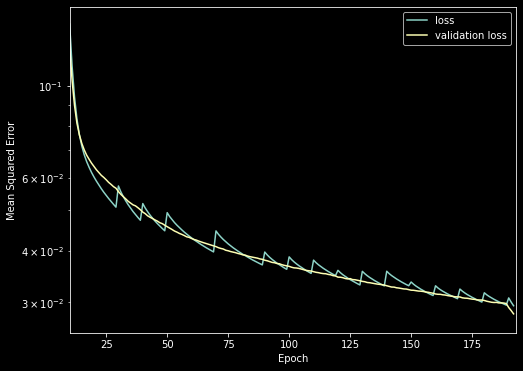

In [57]:
# set axes limits to adapt to epoch range
xmin = 10
xmax = len(loss_history['loss'])
ymin = np.min(loss_history['loss'][xmin:] + loss_history['val_loss'][xmin:])*0.9
ymax = np.max(loss_history['loss'][xmin:] + loss_history['val_loss'][xmin:])*1.1

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.plot(loss_history['loss'], label='loss')
ax.plot(loss_history['val_loss'], label='validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')
ax.set_yscale('log')
ax.legend()
plt.show()

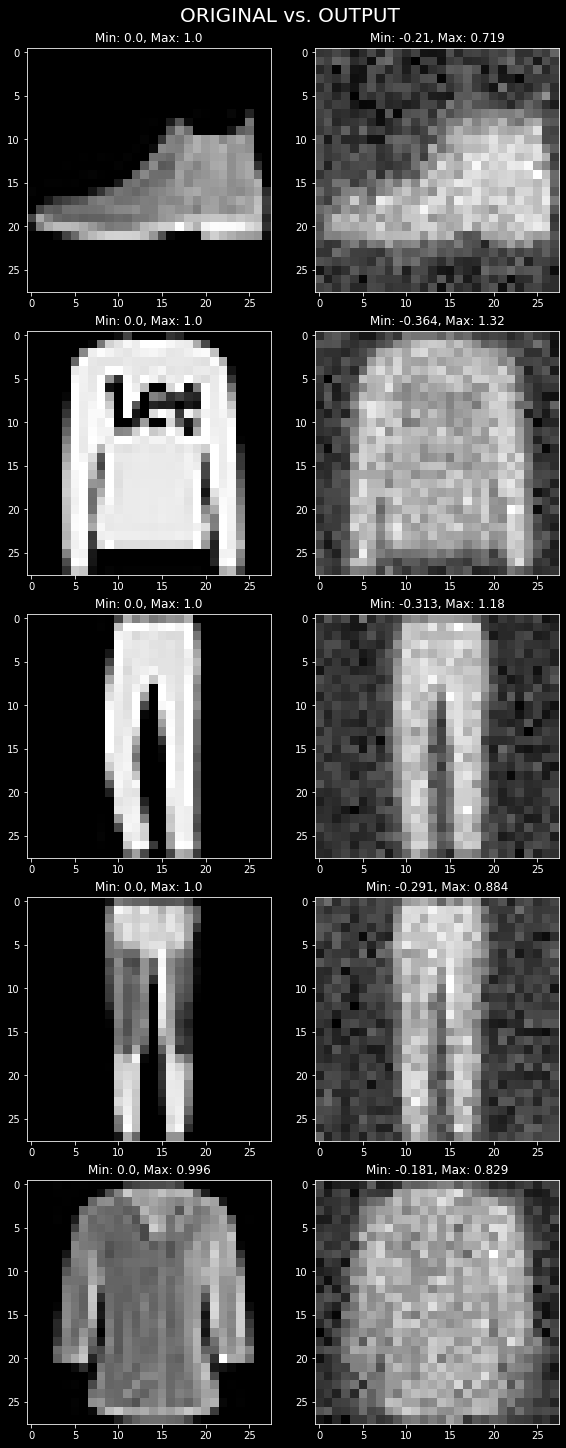

In [59]:
idx = 0
original_images = np.reshape(y_test[idx:idx+5], (5,28,28))
output_images = np.reshape(full_model(x_test[idx:idx+5]), (5,28,28))

# plot original and noisy images side-by-side
fig, axs = plt.subplots(5,2, figsize=(8,20),
                       constrained_layout=True)
fig.suptitle('ORIGINAL vs. OUTPUT', fontsize=20)
for i in range(5):
    # plot original image on the left
    left_title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(original_images[i,:,:]),
        np.max(original_images[i,:,:]))
    axs[i,0].set_title(left_title)
    axs[i,0].imshow(original_images[i,:,:],
                    cmap='gray')
    
    # plot noisy image on the right
    right_title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(output_images[i,:,:]),
        np.max(output_images[i,:,:]))
    axs[i,1].set_title(right_title)
    axs[i,1].imshow(output_images[i,:,:],
                    cmap='gray')
plt.show()

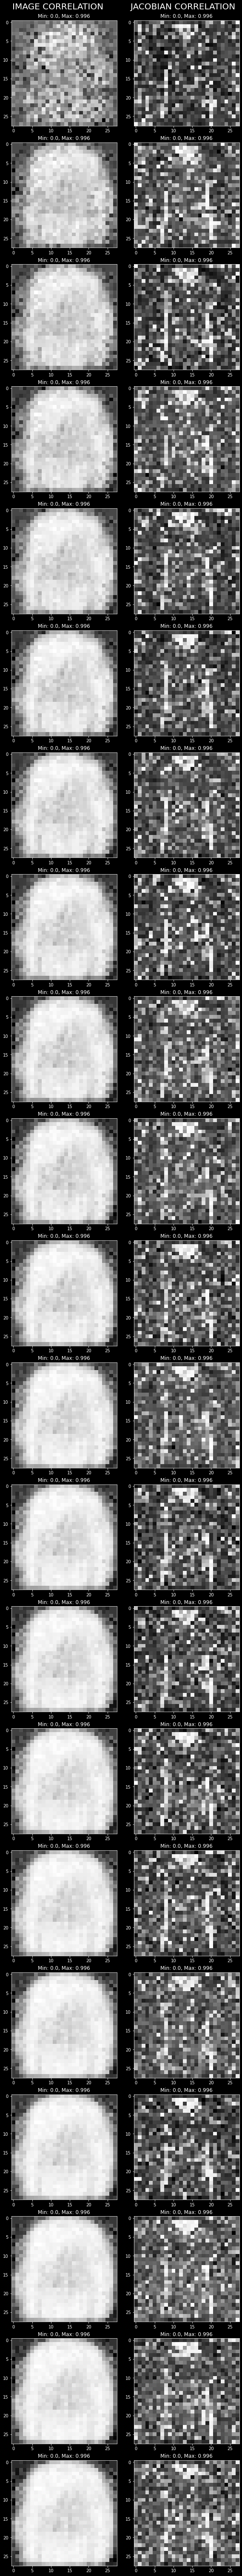

In [71]:
# PLOT CORRELATION HISTORIES
nrows = len(image_corr_history)
fig, axs = plt.subplots(nrows,2, figsize=(8,nrows*4),
                       constrained_layout=True)
fig.suptitle('IMAGE CORRELATION          JACOBIAN CORRELATION', fontsize=20)
for row in range(nrows):
    # plot original image on the left
    left_title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(original_images[i,:,:]),
        np.max(original_images[i,:,:]))
    axs[row,0].set_title(left_title)
    axs[row,0].imshow(image_corr_history[row],
                    cmap='gray')
    
    # plot noisy image on the right
    right_title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(original_images[i,:,:]),
        np.max(original_images[i,:,:]))
    axs[row,1].set_title(right_title)
    axs[row,1].imshow(JJt_corr_history[row],
                    cmap='gray')
plt.show()

In [ ]:
batch_size = 50
# add noise to input vectors x_test
sigma = np.std(x_test[:batch_size])/5 # choose sigma = 1/5 of original std
x = x_test[:batch_size] + sigma*np.random.randn(batch_size, 3920)
# reshape original and output batches of vectors into batches of images
output_shirts = np.reshape(full_model(x), (batch_size,28,28))
original_shirts = np.reshape(y_test[:batch_size], (batch_size,28,28))
# get the deviation^2 pixel by pixel
dev_sqs = (output_shirts - original_shirts)**2
# get batch of JJt diagonals (each length 784) and reshape into 
# a batch of 28x28 "images"
JJt_diags = np.reshape(batch_JJt_diag(x_test[:batch_size], full_model),
                       (batch_size,28,28))
print('sigma^2(J * Jt)')
print(JJt_diags[0] * sigma**2)
# add correlation of dev_sq and JJt_diags to correlation history
error_corr = pixel_corr(dev_sqs, JJt_diags)

In [72]:
# Plot deviations squared, diagonal of JJt for 5 example images
# plot original and noisy images side-by-side
fig, axs = plt.subplots(5,2, figsize=(8,20),
                       constrained_layout=True)
fig.suptitle('DEVIATION^2        J*Jt DIAGONAL', fontsize=20)
for i in range(5):
    # plot original image on the left
    left_title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(original_images[i,:,:]),
        np.max(original_images[i,:,:]))
    axs[i,0].set_title(left_title)
    axs[i,0].imshow(original_images[i,:,:],
                    cmap='gray')
    
    # plot noisy image on the right
    right_title = "Min: {0:.3}, Max: {1:.3}".format(
        np.min(output_images[i,:,:]),
        np.max(output_images[i,:,:]))
    axs[i,1].set_title(right_title)
    axs[i,1].imshow(output_images[i,:,:],
                    cmap='gray')
plt.show()

KeyboardInterrupt: 